In [ ]:
import sys
import os
from tqdm import tqdm
# from src.models.setup_model import setup_sam2, load_sam2

# Aggiunge il percorso del progetto al PYTHONPATH
current_dir = os.path.abspath(os.getcwd())
project_home_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

sys.path.append(project_home_dir)

# # Carica il modello SAM2
# setup_sam2(project_home_dir)
# predictor = load_sam2(project_home_dir)

In [ ]:
import src.data.make_dataset as make_dataset
import src.data.image_info as image_info

slice_dict = make_dataset.load_image_slices(os.path.join(project_home_dir, r"data\raw"))
masks_path_list = {
    'BZ2': r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_BZ2_preprocessed_collagen_tissue_mask.png",
    'BZ3': r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_BZ3_preprocessed_collagen_tissue_mask.png",
    'BZ5': r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_BZ5_preprocessed_collagen_tissue_mask.png",
    'BZ6': r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_BZ6_preprocessed_collagen_tissue_mask.png",
    'RE1': r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_RE1_preprocessed_collagen_tissue_mask.png",
    'RE2': r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_RE2_preprocessed_collagen_tissue_mask.png",
}


for slice_id in tqdm(slice_dict):
    mask_path = masks_path_list[slice_id]
    imageInfo = image_info.ImageSlice(slice_id)
    imageInfo.load_images(slice_dict[slice_id]['wga'], slice_dict[slice_id]['collagen'], slice_dict[slice_id]['autofluorescence'])
    imageInfo.analyse_image2(mask_path)
    imageInfo.save_results()

In [3]:
import cv2
import numpy as np
from skimage.segmentation import slic
from src.data.pre_process_image import enhance_image
from src.data.pre_process_image import load_tif_image, resize_image
from src.data.pre_process_image import generate_superpixels
import src.models.segmentation as seg
import src.visualization.visualize as vis

mask = cv2.imread(r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_BZ2_preprocessed_collagen_tissue_mask.png", cv2.IMREAD_GRAYSCALE)
image  = load_tif_image(r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\data\raw\BZ2_BZ2_CH1_AUTO_MIP.tif")
image = resize_image(image, 0.5)
image = enhance_image(image, mask)

segments = generate_superpixels(image, mask, n_superpixels=600)

# superpixel_viz, segmented_viz = seg.superpixel_rag_segmentation(image, mask, segments=segments)


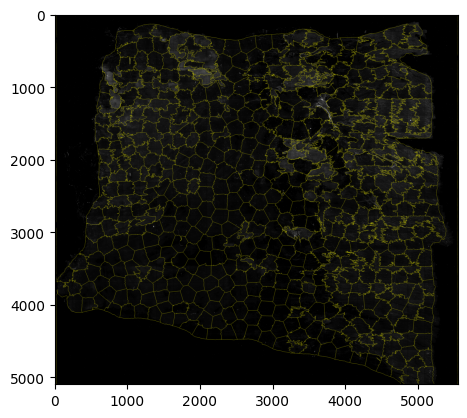

In [6]:
from src.visualization.visualize import visualize_superpixels_with_boundaries
v = visualize_superpixels_with_boundaries(image, segments)
import matplotlib.pyplot as plt
plt.imshow(v)

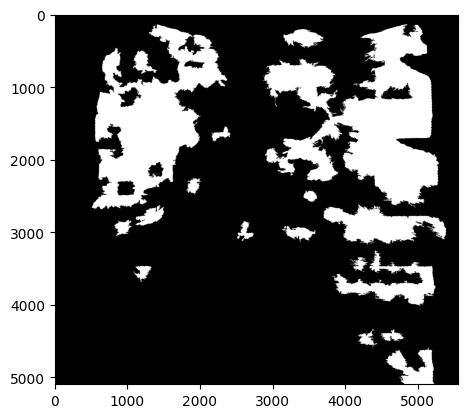

In [14]:
from skimage.segmentation import mark_boundaries
from skimage.segmentation import find_boundaries
from skimage.segmentation import clear_border
from skimage.measure import label
from skimage import filters

def create_binary_mask_otsu(img, labels):
    """
    Crea una maschera binaria per l'immagine `img` basata sui superpixel.
    La maschera viene creata utilizzando la soglia di Otsu applicata ai colori medi dei superpixel.
    
    Parameters
    ----------
    img : ndarray
        L'immagine originale.
    labels : ndarray
        Le etichette dei superpixel ottenute tramite SLIC o altro metodo di segmentazione.
    
    Returns
    -------
    binary_mask : ndarray
        La maschera binaria risultante dai superpixel.
    """
    # Calcolare il colore medio di ogni superpixel
    mean_colors = np.zeros((np.max(labels), 3))
    for i in range(1, np.max(labels) + 1):
        # Maschera per ogni superpixel
        mask = (labels == i)
        mean_colors[i - 1] = np.mean(img[mask], axis=0)
    
    # Convertire il colore medio in una singola intensità (usando la luminanza)
    # Formula ponderata per la luminanza
    gray_mean_colors = 0.2989 * mean_colors[:, 0] + 0.5870 * mean_colors[:, 1] + 0.1140 * mean_colors[:, 2]
    
    # Applicare la soglia di Otsu
    threshold = filters.threshold_otsu(gray_mean_colors)
    
    # Creare la maschera binaria
    binary_mask = np.zeros_like(labels, dtype=bool)
    
    # Assegnare True ai superpixel che superano la soglia
    for i in range(1, np.max(labels) + 1):
        # Maschera per ogni superpixel
        mask = (labels == i)
        # Se il colore medio di un superpixel è maggiore della soglia, imposta la maschera a True
        if gray_mean_colors[i - 1] >= threshold:
            binary_mask[mask] = True
    
    return binary_mask

binary_mask = create_binary_mask_otsu(image, segments)
plt.imshow(binary_mask, cmap='gray')
plt.show()